### Import important modules and declare important directories

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
import pandas as pd
import csv
import os
import re

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

filename = "cleaned_reviews_states.json"

#### RENAME THESE DIRECTORIES TO MATCH YOUR OWN

In [1]:
#This is the main folder where all the modules and JSON files are stored
file_directory = "/Users/robertsonwang/Desktop/Python/Yelp/"

#### Here, we try to specify word lists to use later in classification

In [81]:
#Load in the Harvard-IV Sentiment Dictionary, then create a new list of only the negative words
harvard_dict = pd.read_csv('HIV-4.csv')
neg_words = list(set(harvard_dict[(harvard_dict.Negativ == 'Negativ')].Entry))
neg_words = [x.lower() for x in pos_neg_words]
cleaned_neg_words =[]
for word in pos_neg_words:
    word = re.sub("#", "", word)
    word = re.sub("\d", "", word)
    cleaned_neg_words.append(word)
cleaned_neg_words = list(set(cleaned_words))

/Users/robertsonwang/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (63,108,109,110,176) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
#Here we build a list of sentiment words using past studies and analysis
sentiment_words = ['worst', 'rude', 'terrible', 'horrible', 'bad', 'soggy', 'disappointing', 'overcooked', 'sorry',
                 'awful', 'disgusting', 'bland', 'tasteless', 'gross', 'mediocre', 'worse', 'poor', 
                 'sexy', 'sensual', 'seductive', 'voluptuously', 'ravishing', 'ok', 'perfection', 'thank',
                 'loved', 'reasonable', 'incredible', 'masterpiece', 'responsible', 'top-quality', 'fantastic!',
                 'incompetent', 'fuck-up', 'spiders', 'yikes', 'ant', 'overpriced',
                 'hedonistic', 'drug', 'addicting', 'addicted', 'sad', 'barely', 'favorite', 'favorites', 'die',
                 'awesome', 'glad', 'delicious', 'dry', 'money', 'unfortunately', 'frozen']

### Load in the JSON file, note that reviews_json loads in as a list of dictionaries

In [62]:
reviews_json = json.load(open(file_directory+filename))

In [59]:
states = ['AZ', 'IL', 'WI', 'OH', 'NC', 'NV']
for review in reviews_json[670000:680000]:
    for state in states:
        if review['state'] == state:
            if len(state_dict[state]) > 5000:
                continue
            else:
                try:
                    state_dict[state].append(review)
                except KeyError:
                    state_dict[state] = [review]
        else:
            continue
with open('cleaned_reviews_subset', 'w') as outfile:
    json.dump(state_dict, outfile)

In [45]:
#For each of the entries in the review list, 
#we can treat it like a dictionary and call specific portions of that dictionary
print reviews_json[0]['text']
print reviews_json[0]['stars']

This place is a area staple! Been around for years and not much has changed - I see this as a good thing! Stable and reliable!

My family goes every year for St. Pattys Day corn beef! Very nice place for a bar night dinner, or to catch up with some friends over drinks!
4


In [9]:
#We have about 2 million reviews
len(reviews_json)

1951815

In [ ]:
#This is way too many. We will only focus on a the collecting a random set of 5000 reviews from each state.
states = ['AZ', 'IL', 'WI', 'OH', 'NC', 'NV']
star_dict = {}
df_list = []
for state in states:
    star_dict[state] = []
    for review in state_dict[state]:
        star_dict[state].append(review['stars'])
    star_df =  pd.DataFrame({'Ratings':star_dict[state]})
    df_list.append(star_df)

#### Now, let's create two lists: 
* One that holds all the reviews 
* One that holds all the ratings

In [25]:
reviews = []
stars = []
for review in review_subset:
    reviews.append(review['text'])
    stars.append(review['stars'])
print reviews[1]
print stars[1]

Got my mojo back after having a few of their appetite teasers. Love LPW for a no-frills bite to eat.
4


#### Let's plot the distribution of the ratings of this subset of reviews based on state

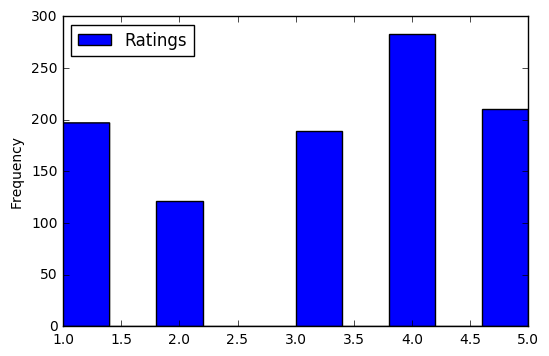

In [26]:
star_hist = pd.DataFrame({'Ratings':stars})
star_hist.plot.hist()

### Now let's try to build a simple linear support vector machine

In [44]:
train_reviews = reviews[0:800]
test_reviews = reviews[800:1000]
train_ratings = stars[0:800]

In [55]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 200) 

train_data_features = vectorizer.fit_transform(train_reviews)
test_data_features = vectorizer.transform(test_reviews)

In [56]:
lin_svm = svm.LinearSVC(multi_class='crammer_singer')
lin_svm = lin_svm.fit(train_data_features, train_ratings)
lin_svm_result = lin_svm.predict(test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": stars[800:1000], "Predicted_Rating":lin_svm_result} )
output['Lin_SVM_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['Lin_SVM_Accurate']))/float(len(output))

print accurate_percentage

0.43


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()[0:200]
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    #create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

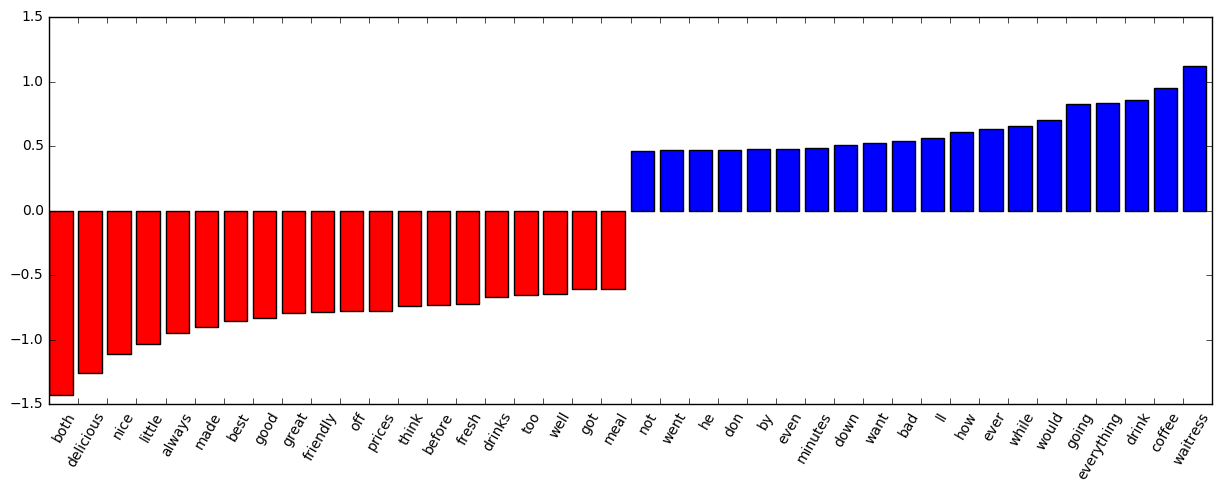

In [60]:
plot_coefficients(lin_svm, vectorizer.get_feature_names())

#### Let's plot the rating distribution within each of the states. Note, this is the distribution of review ratings.

AZ Rating Distribution


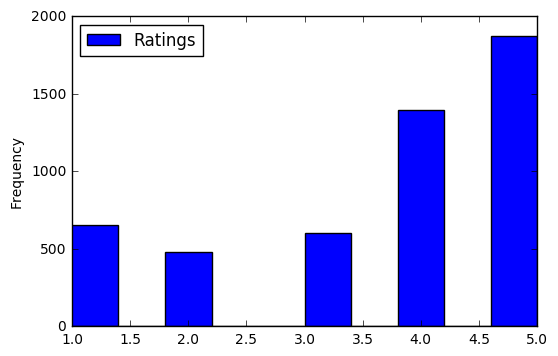

IL Rating Distribution


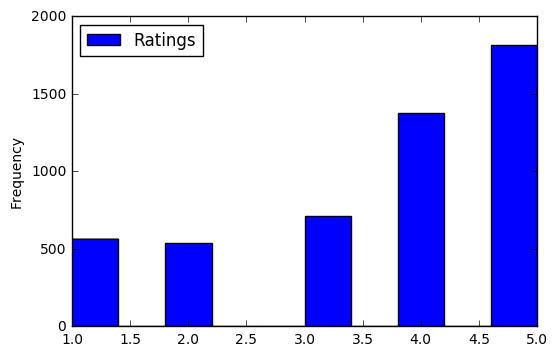

WI Rating Distribution


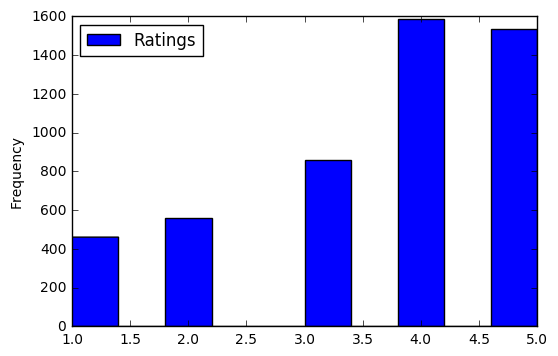

OH Rating Distribution


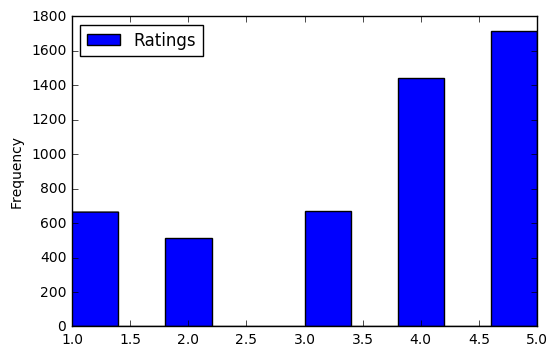

NC Rating Distribution


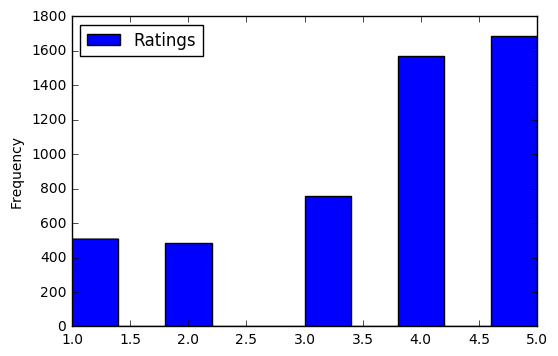

NV Rating Distribution


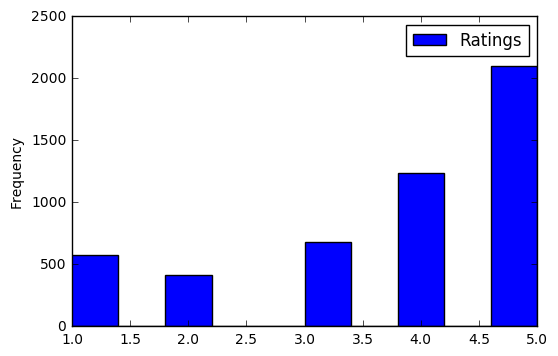

In [71]:
for i in range(0, len(df_list)):
    print states[i] + " Rating Distribution"
    df_list[i].plot.hist()
    plt.show()

In [73]:
#Build an aggregated list of reviews as well as an aggregated list of stars
states = ['AZ', 'IL', 'WI', 'OH', 'NC', 'NV']
star_list = []
review_list = []
for state in states:
    for review in state_dict[state]:
        review_list.append(review['text'])
        star_list.append(review['stars'])

30006
30006


In [324]:
for n,i in enumerate(star_list):
    if i==1:
        star_list[n]='bad'
    if i==2:
        star_list[n]='bad'
    if i==3:
        star_list[n]='bad'
    if i==4:
        star_list[n]='good'
    if i==5:
        star_list[n]='good'

In [222]:
#Separate out a random set of 5000 reviews into different ratings lists, then find the unique words in each list
fives = []
fours = []
threes = []
twos = []
ones = []
for state in states:
    for review in state_dict[state][0:1000]:
        if review['stars'] == 5:
            fives.append(review['text'])
        elif review['stars'] == 4:
            fours.append(review['text'])
        elif review['stars'] == 3:
            threes.append(review['text'])
        elif review['stars'] == 2:
            twos.append(review['text'])
        elif review['stars'] == 1:
            ones.append(review['text'])

In [256]:
import re
punctuation = ['(', ')', '?', ':', ';', ',', '.', '!', '/', '"', "'"]
ratings_words_list = [ones, twos, threes, fours, fives]
cleaned_word_list = {}
for rating_word_list in ratings_words_list:
    rating_word_list = [x.split(".") for x in rating_word_list]
    rating_word_list = [item for sublist in rating_word_list for item in sublist]
    rating_word_list = [x.split(" ") for x in rating_word_list]
    rating_word_list = [item for sublist in rating_word_list for item in sublist]
    rating_word_list = [x for x in rating_word_list if re.match('[a-zA-Z]', x)]
    rating_word_list = [re.sub('\n','', x) for x in rating_word_list]
    rating_word_list = [x.lower() for x in rating_word_list]

In [297]:
threes = [x.split(".") for x in threes]
threes = [item for sublist in threes for item in sublist]
threes = [x.split(" ") for x in threes]
threes = [item for sublist in threes for item in sublist]
threes = [x for x in threes if re.match('[a-zA-Z]', x)]
threes = [re.sub('\n','', x) for x in threes]
threes = [x.lower() for x in threes]

In [328]:
#Build a test set and a training set for reviews
test_amount = int(0.8 * len(review_list))
train_reviews = review_list[0:test_amount] 
train_stars = star_list[0:test_amount]
test_reviews = review_list[test_amount:len(review_list)] 
test_stars = star_list[test_amount:len(star_list)] 

In [338]:
##Naive Linear SVM, no text pre-processing whatsoever
baseline_vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             binary = 1,   \
                             max_features = 500) 

tf_transformer = TfidfTransformer(use_idf=True)

baseline_train_data_features = baseline_vectorizer.fit_transform(train_reviews)
baseline_test_data_features = baseline_vectorizer.transform(test_reviews)

baseline_train_data_features = tf_transformer.fit_transform(baseline_train_data_features)
baseline_test_data_features = tf_transformer.fit_transform(baseline_test_data_features)

In [ ]:
import timeit
import profile 
start = time.time()
#do work here
elapsed = time.time() - start
print elapsed

#### What we should be doing is using one dataframe, collecting the results in that dataframe and then exporting it to a .csv for later use
#### We'd be able to make a quick visualization for each rating system: (accurate rating, predicted rating), one hundred percent accuracy is the 45 degree line, any deviation outside of that will be incorrect

In [97]:
bag_dt = BaggingClassifier(n_estimators=500, n_jobs=-1)
bag_dt = bag_dt.fit(train_data_features, train_stars)
bag_dt_result = bag_dt.predict(test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": test_stars, "Predicted_Rating":bag_dt_result} )
output['Bag_DT_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['Bag_DT_Accurate']))/float(len(output))

print accurate_percentage

0.524166666667


#### Test results using all of the states

* 0.5383 from Naive TF-IDF Linear SVM
* 0.4567 from Naive TF-IDF Linear SVM using Harvard-IV dictionary
* 0.5241 from Naive TF-IDF Bagged DT using 100 estimators
* 0.496 from Naive TF-IDF Bagged DT using 100 estimators and Harvard-IV dictionary
* 0.5156 from Naive TF-IDF RandomForest and Harvard-IV dictionary
* 0.53 from Naive TF-IDF RF
* 0.458 from Naive TF-IDF SVM

In [330]:
##Use the Harvard-IV negative Dictionary
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             vocabulary = cleaned_words, \
                             stop_words = 'english',   \
                             max_features = None) 

tf_transformer = TfidfTransformer(use_idf=True)

train_data_features = vectorizer.fit_transform(train_reviews)
test_data_features = vectorizer.transform(test_reviews)

train_data_features = tf_transformer.fit_transform(train_data_features)
test_data_features = tf_transformer.fit_transform(test_data_features)
vocab = vectorizer.get_feature_names()

In [312]:
lin_svm = svm.LinearSVC(multi_class='crammer_singer')
lin_svm = lin_svm.fit(train_data_features, train_stars)
lin_svm_result = lin_svm.predict(test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": test_stars, "Predicted_Rating":lin_svm_result} )
output['Lin_SVM_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['Lin_SVM_Accurate']))/float(len(output))

print accurate_percentage

In [320]:
#Try a RandomForest classifier
forest = RandomForestClassifier(n_estimators = 200, criterion ='entropy')
forest = forest.fit(train_data_features, train_stars)
rf_result = forest.predict(test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": test_stars, "Predicted_Rating":rf_result} )
output['RF_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['RF_Accurate']))/float(len(output))

print accurate_percentage

0.5235


In [321]:
bag_dt = BaggingClassifier(n_estimators=200, n_jobs=-1)
bag_dt = bag_dt.fit(train_data_features, train_stars)
bag_dt_result = bag_dt.predict(test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": test_stars, "Predicted_Rating":bag_dt_result} )
output['Bag_DT_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['Bag_DT_Accurate']))/float(len(output))

print accurate_percentage

In [339]:
svm_classifier = SGDClassifier(loss='perceptron', shuffle = False, eta0=10e-100, learning_rate='invscaling')
svm_classifier = svm_classifier.fit(baseline_train_data_features, train_stars)
svm_result = svm_classifier.predict(baseline_test_data_features)

output = pd.DataFrame( data={"Reviews": test_reviews, "Rating": test_stars, "Predicted_Rating":svm_result} )
output['SVM_Accurate'] = np.where(output['Rating'] == output['Predicted_Rating'], 1, 0)
accurate_percentage = float(sum(output['SVM_Accurate']))/float(len(output))

print accurate_percentage

0.803565478174


In [337]:
print metrics.confusion_matrix(test_stars, svm_result, labels = ['good', 'bad'])

[[3673  287]
 [1117  925]]
